# Performance de un ajuste

In [1]:
%matplotlib notebook

In [2]:
pip install boost-histogram

Note: you may need to restart the kernel to use updated packages.


In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.optimize import minimize
import boost_histogram as bh

In [4]:
S0 = 19.1
beta = 2.1
theta = np.array([S0, beta])

In [5]:
xdata = np.array([191, 263, 309])  # distancia en metros

In [6]:
nsimulaciones = 10000

Semilla random para reproducir los resultados

In [7]:
np.random.seed(seed=60870)

In [8]:
def modelo(x, theta):
    S0 = theta[0]
    beta = theta[1]
    x0 = 250
    return S0 * np.power(x/x0, -beta)

In [9]:
mu = modelo(xdata, theta)
mu

array([33.61532498, 17.17118683, 12.24037093])

<IPython.core.display.Javascript object>


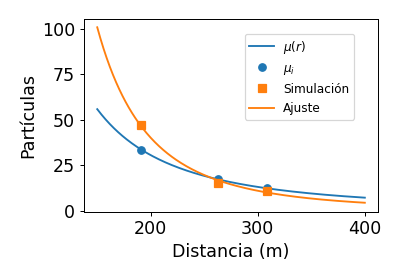

Text(0, 0.5, 'Partículas')

In [10]:
fig1 = plt.figure( figsize=(5, 3.5) ) 
ax1 = fig1.subplots()
ax1.set_xlabel('Distancia (m)')
ax1.set_ylabel('Partículas')

In [11]:
x = np.linspace(150, 400, 256)
y = modelo(x, theta)
ax1.plot(x, y, color='tab:blue', label='$\mu(r)$')
ax1.plot(xdata, mu, ls='none', marker='o', color='tab:blue', label='$\mu_i$')

## Función de costo

In [12]:
def funcion_costo(theta, xdata, ydata):
        costo = np.zeros_like(theta[0])
        for (x1, y1) in zip(xdata, ydata):
            mu1 = modelo(x1, theta)
            costo += (mu1-y1) - y1 * np.log(mu1/y1)
        return 2*costo

In [13]:
S0_est = []
beta_est = []
error_S0 = []
error_beta = []
costo_min = []

In [14]:
for i in range(nsimulaciones):
    
    ydata = poisson.rvs(mu)
    J = lambda theta: funcion_costo(theta, xdata, ydata) 
    
    res = minimize(J, x0=theta)
    if not res.success:
        print(message)
        exit()
        
    S0_est.append(res.x[0])
    beta_est.append(res.x[1])
    
    cova = 2*res.hess_inv
    errores = np.sqrt( np.diagonal(cova) )
    error_S0.append(errores[0])
    error_beta.append(errores[1])
    
    costo_min.append(res.fun)

## Dibujar la última simulación

In [15]:
ax1.plot(xdata, ydata, ls='none', marker='s', color='tab:orange', label='Simulación')
mu = modelo(x, res.x)
ax1.plot(x, mu, color='tab:orange', label='Ajuste')
fig1.legend(bbox_to_anchor=(0.9,0.9), loc='upper right')
fig1.savefig('performance_ajuste1.svg')

## Performance de los estimadores de los parámetros

In [16]:
S0_est

[20.286088146707446,
 21.519947069769415,
 19.214244705338977,
 21.229829117734802,
 13.286599459142197,
 20.602162266792877,
 20.68085195235766,
 21.318710876230952,
 23.01626072264715,
 20.009859548557696,
 22.40435089978998,
 16.193500427401528,
 20.35005187819634,
 24.005289730352818,
 21.19191905187903,
 17.2488748286557,
 15.675066282921703,
 18.63781307246695,
 25.714606914265477,
 19.735832228886864,
 19.86189849340609,
 20.36817859628002,
 18.803654131750545,
 21.337135971483203,
 16.291834863647015,
 14.76144717289671,
 21.042312835301477,
 19.26090600522895,
 21.032980670624358,
 16.697455158688253,
 16.601820613359553,
 18.466697741693775,
 19.665685078459017,
 17.920336792668333,
 17.16350251819954,
 15.86620317938865,
 12.783026802428502,
 20.753321914043134,
 18.1622967708941,
 20.944209004456443,
 17.648750837919813,
 16.852798365914218,
 19.951502920640188,
 19.887196355706532,
 21.144618121592288,
 19.87830480451656,
 23.184890789244776,
 19.287883363281292,
 18.84273

In [17]:
media_S0 = np.mean(S0_est)
media_S0

18.91979054888155

In [18]:
sesgo_S0 = media_S0 - S0
sesgo_S0

-0.18020945111845066

In [19]:
sigma_S0 = np.std(S0_est, ddof=1)
sigma_S0

2.6472778450339245

In [20]:
sigma_S0_mean = sigma_S0 / math.sqrt(len(S0_est))
sigma_S0_mean

0.026472778450339244

In [21]:
print(f'Sesgo estimador de S₀: {sesgo_S0:.3f} ± {sigma_S0_mean:.3f}')
print(f'Desviación estándar del estimador de S₀: {sigma_S0:.2f}')

Sesgo estimador de S₀: -0.180 ± 0.026
Desviación estándar del estimador de S₀: 2.65


In [22]:
0.099 / 0.086

1.1511627906976745

In [23]:
media_beta = np.mean(beta_est)
sigma_beta = np.std(beta_est, ddof=1)
sesgo_beta = media_beta - beta
sigma_beta_mean = sigma_beta / math.sqrt(len(beta_est))
print(f'Sesgo estimador de β: {sesgo_beta:.3f} ± {sigma_beta_mean:.3f}')
print(f'Desviación estándar del estimador de β: {sigma_beta:.2f}')

Sesgo estimador de β: 0.019 ± 0.007
Desviación estándar del estimador de β: 0.65


## Histogramas de los estimadores

In [24]:
histo_S0 = bh.Histogram(bh.axis.Regular(bins=50, start=10, stop=30))
histo_S0.fill(S0_est)

Histogram(Regular(50, 10, 30), storage=Double()) # Sum: 9999.0 (10000.0 with flow)

In [25]:
histo_beta = bh.Histogram(bh.axis.Regular(bins=50, start=0, stop=5))
histo_beta.fill(beta_est)

Histogram(Regular(50, 0, 5), storage=Double()) # Sum: 9993.0 (10000.0 with flow)

<IPython.core.display.Javascript object>


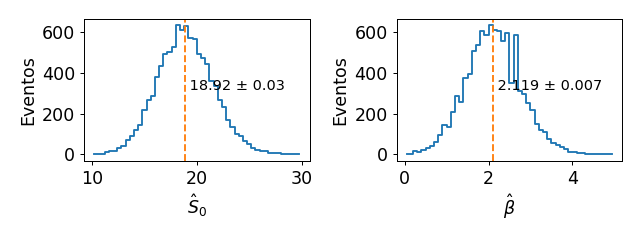

In [26]:
fig2 = plt.figure( figsize=(8,3) ) 
ax2a, ax2b = fig2.subplots(ncols=2)

In [27]:
ax2a.set_xlabel('$\hat{S}_0$')
ax2a.set_ylabel('Eventos')
ax2a.plot(histo_S0.axes.centers[0], histo_S0.values(), drawstyle='steps-mid', color='tab:blue')
ax2a.axvline(media_S0, ls='--', color='tab:orange')
ax2a.text(media_S0, 0.5, f' {media_S0:.2f} ± {sigma_S0_mean:.2f} ', transform=ax2a.get_xaxis_transform(), fontsize="small")

Text(18.91979054888155, 0.5, ' 18.92 ± 0.03 ')

In [28]:
ax2b.set_xlabel('$\hat{β}$')
ax2b.set_ylabel('Eventos')
ax2b.plot(histo_beta.axes.centers[0], histo_beta.values(), drawstyle='steps-mid', color='tab:blue')
ax2b.axvline(media_beta, ls='--', color='tab:orange')
ax2b.text(media_beta, 0.5, f' {media_beta:.3f} ± {sigma_beta_mean:.3f}', transform=ax2b.get_xaxis_transform(), fontsize="small")

Text(2.1189292699468827, 0.5, ' 2.119 ± 0.007')

In [29]:
fig2.savefig('performance_ajuste2.svg')

## Histogramas de los errores

In [30]:
histo_error_S0 = bh.Histogram(bh.axis.Regular(bins=50, start=1.5, stop=3.5))
histo_error_S0.fill(error_S0)

Histogram(Regular(50, 1.5, 3.5), storage=Double()) # Sum: 10000.0

In [31]:
histo_error_beta = bh.Histogram(bh.axis.Regular(bins=50, start=0.4, stop=0.9))
histo_error_beta.fill(error_beta)

Histogram(Regular(50, 0.4, 0.9), storage=Double()) # Sum: 9999.0 (10000.0 with flow)

<IPython.core.display.Javascript object>


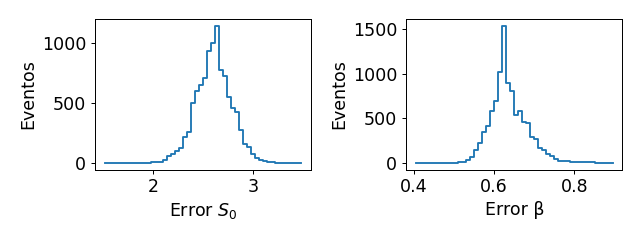

In [32]:
fig3 = plt.figure( figsize=(8,3) ) 
ax3a, ax3b = fig3.subplots(ncols=2)

In [33]:
ax3a.set_xlabel('Error $S_0$')
ax3a.set_ylabel('Eventos')
ax3a.plot(histo_error_S0.axes.centers[0], histo_error_S0.values(), drawstyle='steps-mid', color='tab:blue')

In [34]:
ax3b.set_xlabel('Error β')
ax3b.set_ylabel('Eventos')
ax3b.plot(histo_error_beta.axes.centers[0], histo_error_beta.values(), drawstyle='steps-mid', color='tab:blue')

In [35]:
fig3.savefig('performance_ajuste3.svg')

## Cobertura de los intervalos de confianza

In [36]:
def cobertura(estimadores, errores, par):
    minimo = np.array(estimadores) - np.array(errores)
    maximo = np.array(estimadores) + np.array(errores)
    exitos = ((par-minimo)*(par-maximo)<0).sum()
    ndatos = len(estimadores)
    cobertura = exitos/ndatos
    error_cobertura = math.sqrt(cobertura*(1-cobertura)/ndatos)
    return (cobertura, error_cobertura)

In [37]:
cobertura_S0, error_cobertura_S0 = cobertura(S0_est, error_S0, S0)
print(f'Cobertura intervalo S0: ({cobertura_S0*100:.1f} ± {error_cobertura_S0*100:.1f})%')

Cobertura intervalo S0: (67.5 ± 0.5)%


In [38]:
cobertura_beta, error_cobertura_beta = cobertura(beta_est, error_beta, beta)
print(f'Cobertura intervalo β: ({cobertura_beta*100:.1f} ± {error_cobertura_beta*100:.1f})%')

Cobertura intervalo β: (68.3 ± 0.5)%


## Bondad del ajuste

In [39]:
costo_min_obs = 0.32967858568717334
ncola = np.sum(np.array(costo_min)>costo_min_obs)
nsimulados = len(costo_min)
pvalor = ncola / nsimulados
error_pvalor = math.sqrt(pvalor*(1-pvalor)/nsimulados)
print(f'pvalor numérico: ({pvalor*100:.1f} ± {error_pvalor*100:.1f})%')

pvalor numérico: (56.8 ± 0.5)%


In [40]:
xmin, xmax = 0, 5
histo_costo = bh.Histogram(bh.axis.Regular(bins=20, start=xmin, stop=xmax))
histo_costo.fill(costo_min)

Histogram(Regular(20, 0, 5), storage=Double()) # Sum: 9721.0 (10000.0 with flow)

In [41]:
ndof = len(xdata) - len(theta)
pvalor = chi2.sf(costo_min, df=ndof)

In [42]:
histo_pvalor = bh.Histogram(bh.axis.Regular(bins=20, start=0, stop=1))
histo_pvalor.fill(pvalor)

Histogram(Regular(20, 0, 1), storage=Double()) # Sum: 10000.0

<IPython.core.display.Javascript object>


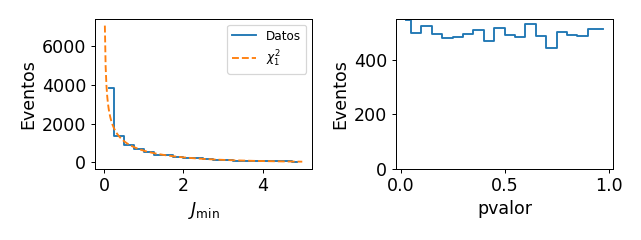

In [43]:
fig4 = plt.figure( figsize=(8,3) ) 
ax4a, ax4b = fig4.subplots(ncols=2)

In [44]:
ax4a.set_xlabel('$J_{\min}$')
ax4a.set_ylabel('Eventos')
ax4a.plot(histo_costo.axes.centers[0], histo_costo.values(), drawstyle='steps-mid', color='tab:blue', label='Datos')

In [45]:
x = np.linspace(xmin, xmax, 256)
bin_width = histo_costo.axes[0].widths[0]
y = chi2.pdf(x, ndof) * nsimulaciones * bin_width 
ax4a.plot(x, y, ls='--', color='tab:orange', label='$\chi^2_1$')
ax4a.legend()

In [46]:
ax4b.set_xlabel('pvalor')
ax4b.set_ylabel('Eventos')
ax4b.plot(histo_pvalor.axes.centers[0], histo_pvalor.values(), drawstyle='steps-mid', color='tab:blue')
ax4b.set_ylim(bottom=0)

(0.0, 553.2)

In [47]:
fig4.savefig('performance_ajuste4.svg')